<a id="top"></a>

# Mapping Galaxy Properties with MaNGA + HST
***

## Learning Goals

By the end of this tutorial, you will:

- Understand how to search the MAST Archive and download SDSS MaNGA data using `astroquery.mast`
- Plot galaxy properties including H-$\alpha$ emission line flux and stellar velocities with MaNGA
- Understand how to search for HST data complementing the MaNGA observations
- Create maps of galaxy properties by combining HST and MaNGA data


## Table of Contents
* [Introduction](#Introduction)
* [Imports](#Imports)
* [Accessing MaNGA data at MAST](#MaNGA)
    * [Querying All MaNGA data](#MaNGA-query)
    * [Searching for a specific galaxy](#MaNGA-galaxy)
    * [Downloading MaNGA data products](#MaNGA-download)
    * [Plotting velocity and flux maps from MaNGA](#MaNGA-plot)
    
* [Searching for HST data of this galaxy](#HST)
    * [Coordinate search using astroquery.mast](#HST-query)
    * [Colorizing HST images with astropy](#HST-colorize)

* [Combining MaNGA and HST data](#HST-MaNGA)
    * [Creating an H-alpha Emission Map](#HST-MaNGA-Halpha)
    * [Plotting the stellar velocity field](#HST-MaNGA-Velocity)

* [Additional Resources](#Resources)
    * [How to Cite](#Citations)
    * [About This Notebook](#About)

## Introduction
<a id="Introduction"></a>

The [Mapping Nearby Galaxies at Apache Point Observatory (MaNGA)](https://www.sdss4.org/surveys/manga/) survey provides optical-wavelength integral field unit (IFU) spectroscopy for over 10,000 nearby galaxies. MaNGA collected data between 2014 - 2020 as part of the [Sloan Digital Sky Survey (SDSS-IV) project](https://www.sdss4.org). MaNGA data is now available at the [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu) through the [SDSS Legacy Archive at MAST](https://outerspace.stsci.edu/display/SDSS/The+SDSS+Legacy+Archive+at+MAST). 

In this notebook tutorial, we will demonstrate how to access MaNGA data at MAST using Python. One MaNGA observation, an interacting galaxy pair named `MaNGA 7443-12703` will be used to demonstrate the basics of how to download and plot MaNGA data. We will then combine this MaNGA data with HST observations, also accessible from MAST, to study this galaxy pair in detail, exploring how its gas and stars are moving as the galaxies merge together.

## Imports
<a id="Imports"></a>

The main packages we're using for this notebook and their use-cases are:
- *astropy.coordinates* for handling astronomical coordinates
- *astroquery.mast Observations* for searching the MAST archive
- *astropy.visualization* for colorizing images
- *astropy.wcs WCS* for handling spatial footprints
- *astropy.units* for working with astronomical units
- *astropy.io fits* for accessing FITS files
- *matplotlib.pyplot* for plotting data
- *numpy* to handle array functions
- *PIL* for plotting and handling preview (png/jpg) images
- *reproject* for coordinate transformations and projections

In [1]:
%matplotlib inline

from astropy.coordinates import SkyCoord
from astroquery.mast import Observations
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS

import astropy.units as u
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
import PIL
import reproject

This cell updates some of the settings in `matplotlib` to use larger font sizes in the figures:

In [2]:
#Update Plotting Parameters
params = {'axes.labelsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 
          'text.usetex': False, 'lines.linewidth': 1,
          'axes.titlesize': 18, 'font.family': 'serif', 'font.size': 12}
plt.rcParams.update(params)

***
<a id="MaNGA"></a>
# Accessing MaNGA data at MAST

The [SDSS Legacy Archive at MAST](https://outerspace.stsci.edu/display/SDSS/The+SDSS+Legacy+Archive+at+MAST) hosts all of the science-ready data products from the [SDSS-IV MaNGA Survey](https://www.sdss4.org/surveys/manga/), which includes data for over 10,000 different nearby galaxies taken with the Apache Point Observatory SDSS-2.5m telescope. This notebook will demonstrate how to search and download MaNGA data using MAST.

<img src="https://www.sdss4.org/wp-content/uploads/2014/07/manga_v3.jpg" alt="The SDSS MaNGA survey obtains spectra across the entire face of target galaxies using custom designed fiber bundles. The title text in the top-center of the image reads 'SDSS-IV Dissects 10,000 Galaxies in Nearby Universe'. In the top left corner is a small inset image of the SDSS 2.5m telescope at Apache Point Observatory, where the MaNGA data was taken. The center-left shows an image of a pair of hands plugging an optical fiber into the MaNGA instrument. The SDSS-IV logo is in the bottom-left. A close-up photo of the MaNGA instrument is shown in the center and bottom-right area of the image, demonstrating that each MaNGA data cube is made from dozens of optical fibers arranged in a hexagon shape, which each take a spectrum at a different location in the galaxy. The top-right inset shows two example spectra from MaNGA, one taken from the center of the fiber bundle (labeled 1) and one taken from the edge of the fiber bundle (labeled 2), showing how the spectrum of the central regions differs dramatically from outer regions. Image Credit: Dana Berry / SkyWorks Digital Inc., David Law, and the SDSS collaboration." width="500px">
<center><i>Image Credit: Dana Berry / SkyWorks Digital Inc., David Law, and the SDSS collaboration.</i></center>




<a id="MaNGA-query"></a>
## Querying all MaNGA data

Searching for MaNGA data is straightforward with `astroquery.mast`. In this example, we use `Observations.query_criteria` and search for `provenance_name = 'MaNGA'`. This will return a table describing all of the MaNGA data hosted by the MAST archive.

Other useful search parameters for MaNGA data might include:
* `obs_collection = 'SDSS'`: searches for all SDSS data
* `target_classification = 'GALAXY'`: searches for only galaxies
* `obs_id` to search for specific targets

In [3]:
# Search for MaNGA data
manga_obs_list = Observations.query_criteria(provenance_name='MaNGA')

# Display First Ten Entries in Table
manga_obs_list[:10]

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str5,str5,str4,str4,str7,str9,str9,str22,float64,float64,str4,str18,int64,float64,float64,float64,float64,float64,str59,float64,str3,str1,int64,str53,str37,str61,str6,bool,float64,str9,str9
science,SDSS,MaNGA,MaNGA,SDSS,None,OPTICAL,1-601561,GALAXY,sdss_manga_12696-1901,13.943292,0.6450414,cube,SDSS Collaboration,3,59080.0,59083.0,13501.2,362.09999999999997,1035.4,Mapping Nearby Galaxies at Apache Point Observatory (MaNGA),59554.0,N/A,--,--,CIRCLE 13.943292 0.6450414 0.001736111111111111,mast:SDSS/manga/12696/1901/1901.png,mast:SDSS/manga/12696/1901/manga-12696-1901-LOGCUBE.fits.gz,PUBLIC,False,nan,232291748,635473185
science,SDSS,MaNGA,MaNGA,SDSS,None,OPTICAL,1-32796,GALAXY,sdss_manga_12696-12704,14.374275,0.10294809,cube,SDSS Collaboration,3,59080.0,59083.0,13501.2,362.09999999999997,1035.4,Mapping Nearby Galaxies at Apache Point Observatory (MaNGA),59554.0,N/A,--,--,CIRCLE 14.374275 0.10294809 0.0045138888888888885,mast:SDSS/manga/12696/12704/12704.png,mast:SDSS/manga/12696/12704/manga-12696-12704-LOGCUBE.fits.gz,PUBLIC,False,nan,232291749,635473584
science,SDSS,MaNGA,MaNGA,SDSS,None,OPTICAL,1-32827,GALAXY,sdss_manga_12696-12705,14.560282,-0.29682866,cube,SDSS Collaboration,3,59080.0,59083.0,13501.2,362.09999999999997,1035.4,Mapping Nearby Galaxies at Apache Point Observatory (MaNGA),59554.0,N/A,--,--,CIRCLE 14.560282 -0.29682866 0.0045138888888888885,mast:SDSS/manga/12696/12705/12705.png,mast:SDSS/manga/12696/12705/manga-12696-12705-LOGCUBE.fits.gz,PUBLIC,False,nan,232291750,635473984
science,SDSS,MaNGA,MaNGA,SDSS,None,OPTICAL,1-32223,GALAXY,sdss_manga_12696-12702,13.427716,-1.0851671,cube,SDSS Collaboration,3,59080.0,59083.0,13501.2,362.09999999999997,1035.4,Mapping Nearby Galaxies at Apache Point Observatory (MaNGA),59554.0,N/A,--,--,CIRCLE 13.427716 -1.0851671 0.0045138888888888885,mast:SDSS/manga/12696/12702/12702.png,mast:SDSS/manga/12696/12702/manga-12696-12702-LOGCUBE.fits.gz,PUBLIC,False,nan,232291751,635474496
science,SDSS,MaNGA,MaNGA,SDSS,None,OPTICAL,1-32708,GALAXY,sdss_manga_12696-12701,13.976234,-0.92219584,cube,SDSS Collaboration,3,59080.0,59083.0,13501.2,362.09999999999997,1035.4,Mapping Nearby Galaxies at Apache Point Observatory (MaNGA),59554.0,N/A,--,--,CIRCLE 13.976234 -0.92219584 0.0045138888888888885,mast:SDSS/manga/12696/12701/12701.png,mast:SDSS/manga/12696/12701/manga-12696-12701-LOGCUBE.fits.gz,PUBLIC,False,nan,232291752,635474974
science,SDSS,MaNGA,MaNGA,SDSS,None,OPTICAL,1-32623,GALAXY,sdss_manga_12696-3703,14.197601,-0.92006382,cube,SDSS Collaboration,3,59080.0,59083.0,13501.2,362.09999999999997,1035.4,Mapping Nearby Galaxies at Apache Point Observatory (MaNGA),59554.0,N/A,--,--,CIRCLE 14.197601 -0.92006382 0.0024305555555555556,mast:SDSS/manga/12696/3703/3703.png,mast:SDSS/manga/12696/3703/manga-12696-3703-LOGCUBE.fits.gz,PUBLIC,False,nan,232291753,635475119
science,SDSS,MaNGA,MaNGA,SDSS,None,OPTICAL,1-32786,GALAXY,sdss_manga_12696-6103,14.210907,0.34647026,cube,SDSS Collaboration,3,59080.0,59083.0,13501.2,362.09999999999997,1035.4,Mapping Nearby Galaxies at Apache Point Observatory (MaNGA),59554.0,N/A,--,--,CIRCLE 14.210907 0.34647026 0.003125,mast:SDSS/manga/12696/6103/6103.png,mast:SDSS/manga/12696/6103/manga-12696-6103-LOGCUBE.fits.gz,PUBLIC,False,nan,232291754,635475317
science,SDSS,MaNGA,MaNGA,SDSS,None,OPTICAL,1-32691,GALAXY,sdss_manga_12696-6102,14.292417,-0.34695556,cube,SDSS Collaboration,3,59080.0,59083.0,13501.2,362.09999999999997,1035.4,Mapping Nearby Galaxies at Apache Point Observatory (MaNGA),59554.0,N/A,--,--,CIRCLE 14.292417 -0.34695556 0.003125,mast:SDSS/manga/12696/6102/6102.png,mast:SDSS/manga/12696/6102/manga-12696-6102-

<a id="MaNGA-galaxy"></a>
## Searching for a specific galaxy

Let's narrow down the search to one particular galaxy: MaNGA galaxy 7443-12703, also known as "Mrk 848B". This is an interacting galaxy pair currently undergoing a merger event: the two galaxies are colliding and will eventually merge together into one large galaxy. Studying merger events like this one help us understand how galaxies grow and evolve over time.  

We can search for this galaxy in particular using the `obs_id` keyword:

In [4]:
# Search for MaNGA galaxy 7443-12703
manga_obs_list = Observations.query_criteria(provenance_name='MaNGA',
                                             obs_id='sdss_manga_7443-12703')

# Display results
manga_obs_list

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str5,str5,str4,str4,str7,str9,str6,str21,float64,float64,str4,str18,int64,float64,float64,float64,float64,float64,str59,float64,str3,str1,int64,str48,str36,str59,str6,bool,float64,str9,str9
science,SDSS,MaNGA,MaNGA,SDSS,None,OPTICAL,12-193481,GALAXY,sdss_manga_7443-12703,229.52558,42.745842,cube,SDSS Collaboration,3,56741.0,56745.0,13501.5,362.09999999999997,1035.4,Mapping Nearby Galaxies at Apache Point Observatory (MaNGA),59554.0,N/A,--,--,CIRCLE 229.52558 42.745842 0.0045138888888888885,mast:SDSS/manga/7443/12703/12703.png,mast:SDSS/manga/7443/12703/manga-7443-12703-LOGCUBE.fits.gz,PUBLIC,False,nan,232291699,636473677


<a id="MaNGA-download"></a>
## Downloading MaNGA data products

List all of the data products availble for this galaxy using `Observations.get_product_list()`.

There are 13 total files available for this galaxy, which include include a preview image (`12703.png`), the 3D MaNGA spectral cube (`manga-7443-12703-LOGCUBE.fits.gz`), and the MaNGA MAP file (`manga-7443-12703-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz`) which contains measurements and parameters from the MaNGA data analysis pipeline.

More information on all of these products can be seen in the search results table:


In [5]:
# Get list of products (files) associated with this observation 
manga_products_list = Observations.get_product_list(manga_obs_list)

# Show Products List
manga_products_list

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str12,str21,str256,str1,str83,str7,str28,str14,str1,str5,str6,str3,str56,int64,str9,str6,int64,str4
232291699,SDSS,cube,sdss_manga_7443-12703,Preview-Full,S,mast:SDSS/manga/7443/12703/12703.png,PREVIEW,--,--,--,MaNGA,v3_1_1,N/A,12703.png,238960,232291699,PUBLIC,3,None
232291699,SDSS,cube,sdss_manga_7443-12703,"SDSS MaNGA IFU Data Cube, with linear wavelength sampling",S,mast:SDSS/manga/7443/12703/manga-7443-12703-LINCUBE.fits.gz,SCIENCE,--,CUBE,--,MaNGA,v3_1_1,N/A,manga-7443-12703-LINCUBE.fits.gz,308685608,232291699,PUBLIC,3,None
232291699,SDSS,cube,sdss_manga_7443-12703,SDSS MaNGA Data Analysis Maps. Same as HYB10-MILESHC-MASTARSSP except hierarchically clustered templates from MaStar are used to fit the stellar continuum in the emission-line module.,S,mast:SDSS/manga/7443/12703/manga-7443-12703-MAPS-HYB10-MILESHC-MASTARHC2.fits.gz,SCIENCE,--,MAPS,--,MaNGA,v3_1_1,N/A,manga-7443-12703-MAPS-HYB10-MILESHC-MASTARHC2.fits.gz,11180464,232291699,PUBLIC,3,None
232291699,SDSS,cube,sdss_manga_7443-12703,SDSS MaNGA Data Analysis Maps. Analysis of each individual spaxel with S/N>1 ; spaxels must have a valid continuum fit for an emission-line model to be fit.,S,mast:SDSS/manga/7443/12703/manga-7443-12703-MAPS-SPX-MILESHC-MASTARSSP.fits.gz,SCIENCE,--,MAPS,--,MaNGA,v3_1_1,N/A,manga-7443-12703-MAPS-SPX-MILESHC-MASTARSSP.fits.gz,10814176,232291699,PUBLIC,3,None
232291699,SDSS,cube,sdss_manga_7443-12703,SDSS MaNGA Data Analysis Maps. Spaxels are binned to S/N~10 using the Voronoi binning algorithm; all binned spectra are treated independently.,S,mast:SDSS/manga/7443/12703/manga-7443-12703-MAPS-VOR10-MILESHC-MASTARSSP.fits.gz,SCIENCE,--,MAPS,--,MaNGA,v3_1_1,N/A,manga-7443-12703-MAPS-VOR10-MILESHC-MASTARSSP.fits.gz,6018405,232291699,PUBLIC,3,None
232291699,SDSS,cube,sdss_manga_7443-12703,SDSS MaNGA Data Analysis Model Cubes. Same as HYB10-MILESHC-MASTARSSP except hierarchically clustered templates from MaStar are used to fit the stellar continuum in the emission-line module.,S,mast:SDSS/manga/7443/12703/manga-7443-12703-LOGCUBE-HYB10-MILESHC-MASTARHC2.fits.gz,SCIENCE,--,MODELCUBE,--,MaNGA,v3_1_1,N/A,manga-7443-12703-LOGCUBE-HYB10-MILESHC-MASTARHC2.fits.gz,178831813,232291699,PUBLIC,3,None
232291699,SDSS,cube,sdss_manga_7443-12703,SDSS MaNGA Data Analysis Model Cubes. Analysis of each individual spaxel with S/N>1 ; spaxels must have a valid continuum fit for an emission-line model to be fit.,S,mast:SDSS/manga/7443/12703/manga-7443-12703-LOGCUBE-SPX-MILESHC-MASTARSSP.fits.gz,SCIENCE,--,MODELCUBE,--,MaNGA,v3_1_1,N/A,manga-7443-12703-LOGCUBE-SPX-MILESHC-MASTARSSP.fits.gz,248679687,232291699,PUBLIC,3,None
232291699,SDSS,cube,sdss_manga_7443-12703,SSDSS MaNGA Data Analysis Model Cubes. Spaxels are binned to S/N~10 using the Voronoi binning algorithm; all binned spectra are treated independently.,S,mast:SDSS/manga/7443/12703/manga-7443-12703-LOGCUBE-VOR10-MILESHC-MASTARSSP.fits.gz,SCIENCE,--,MODELCUBE,--,MaNGA,v3_1_1,N/A,manga-7443-12703-LOGCUBE-VOR10-MILESHC-MASTARSSP.fits.gz,132859770,232291699,PUBLIC,3,None
232291699,SDSS,cube,sdss_manga_7443-12703,"SDSS MaNGA Row-Stacked Spectra, with linear wavelength sampling",S,mast:SDSS/manga/7443/12703/manga-7443-12703-LINRSS.fits.gz,SCIENCE,--,RSS,--,MaNGA,v3_1_1,N/A,manga-7443-12703-LINRSS.fits.gz,247013854,232291699,PUBLIC,3,None


Now we will download some of these files using `Observations.download_products()`. To start, let's download the preview image to see what this galaxy pair looks like. The parameters used are:
* `manga_products_list`: the list of products from the previous cell
* `productType='PREVIEW'`: limit the list to preview files only
* `flat=True`: download the data into the current directory

The download will print a status message when completed.

In [6]:
print(Observations.download_products(manga_products_list, productType='PREVIEW', flat=True))

 [Done]


 Local Path  Status  Message URL 
----------- -------- ------- ----
./12703.png COMPLETE    None None


The Right Ascension (RA) and declination (Dec) coordinates for this image are contained in the file as a [World Coordinate System (WCS)](https://astropy-astrofrog.readthedocs.io/en/latest/wcs/) axis. Using `astropy.wcs.WCS()`, we can retrieve this information from the file and use it in the plot.

In [7]:
def get_wcs_from_png(file):
    """ Retrieves WCS information from png file """
    with PIL.Image.open(file) as ii:
        ww = {}
        for k, v in ii.info.items():
            try:
                ww[k] = float(v)
            except ValueError:
                ww[k] = v
        ww.pop("WCSAXES")
        return WCS(ww)   

Now let's plot this preview image to see what these galaxies look like!

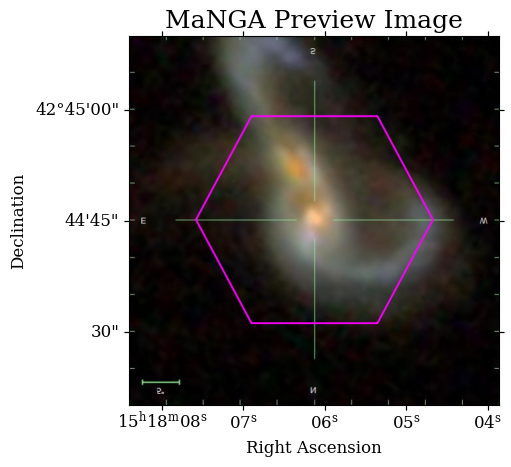

In [8]:
# Open image file
manga_preview = np.asarray(PIL.Image.open('12703.png'))

# Set up plot using WCS projection from the file
plt.subplot(projection=get_wcs_from_png('12703.png'))

# Show the image
plt.imshow(manga_preview)

# Label title and axes
plt.title('MaNGA Preview Image')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

plt.show()

Next, let's download the **Minimum Recommended Products**. These are the recommended files to download for this MaNGA galaxy. You can select the Minimum Recommended Products using `mrp_only=True`. This will download 4 files.

In [9]:
# Download Minimum Recommended Products
Observations.download_products(manga_products_list, mrp_only=True, flat=True)

 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str58,str8,object,object
./manga-7443-12703-LOGCUBE-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None
./manga-7443-12703-LOGCUBE.fits.gz,COMPLETE,None,None
./manga-7443-12703-LOGRSS.fits.gz,COMPLETE,None,None
./manga-7443-12703-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz,COMPLETE,None,None


<a id="MaNGA-plot"></a>
## Plotting velocity and flux maps from MaNGA

Now that the MaNGA data has been downloaded, we can plot some of the galaxy properties. The ManGA MAP file (`manga-7443-12703-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz`) contains the output and results from the [MaNGA Data Analysis Pipeline (DAP)](https://www.sdss4.org/dr17/manga/manga-analysis-pipeline/). This example is based off of the [MaNGA DAP Python Tutorial](https://www.sdss4.org/dr17/manga/manga-tutorials/dap-tutorial/dap-python-tutorial/), and plots the g-band flux, the H-alpha emission line flux, and the stellar velocity field from MaNGA.


The full description of contents of the the MaNGA MAP file is [available here](https://data.sdss.org/datamodel/files/MANGA_SPECTRO_ANALYSIS/DRPVER/DAPVER/DAPTYPE/PLATE/IFU/manga-MAPS-DAPTYPE.html).

Let's open the file and view some basic information:

In [10]:
# Open MaNGA MAP file
manga_map = fits.open('manga-7443-12703-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz')

# Print information on file extensions
manga_map.info()

Filename: manga-7443-12703-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     147   ()      
  1  SPX_SKYCOO    1 ImageHDU        44   (74, 74, 2)   float32   
  2  SPX_ELLCOO    1 ImageHDU        49   (74, 74, 4)   float32   
  3  SPX_MFLUX     1 ImageHDU        37   (74, 74)   float32   
  4  SPX_MFLUX_IVAR    1 ImageHDU        38   (74, 74)   float32   
  5  SPX_SNR       1 ImageHDU        35   (74, 74)   float32   
  6  BINID         1 ImageHDU        46   (74, 74, 5)   int32   
  7  BIN_LWSKYCOO    1 ImageHDU        44   (74, 74, 2)   float32   
  8  BIN_LWELLCOO    1 ImageHDU        49   (74, 74, 4)   float32   
  9  BIN_AREA      1 ImageHDU        36   (74, 74)   float32   
 10  BIN_FAREA     1 ImageHDU        35   (74, 74)   float32   
 11  BIN_MFLUX     1 ImageHDU        38   (74, 74)   float32   
 12  BIN_MFLUX_IVAR    1 ImageHDU        39   (74, 74)   float32   
 13  BIN_MFLUX_MASK    1 Image

To make the plot in the next cell, we will use three different extensions of the MAP file. Here is the description of each of these extensions from the [data model](https://data.sdss.org/datamodel/files/MANGA_SPECTRO_ANALYSIS/DRPVER/DAPVER/DAPTYPE/PLATE/IFU/manga-MAPS-DAPTYPE.html):

* `SPX_MFLUX` 
    * Description: "g-band-weighted mean flux, not corrected for Galactic extinction or internal attenuation."
* The `EMLINE_GFLUX` 
    * Description: "gaussian profile integrated flux from a combined continuum+emission-line fit. The flux ratio of the [NeIII], [OIII], [OI], [NII], and [S III] lines are fixed and cannot be treated as independent measurements. The emission-line fluxes account for Galactic reddening using the E(B-V) (copied to the DAP primary headers, see the EBVGAL header keyword) value provided by the DRP header and assuming an O’Donnell (1994, ApJ, 422, 158) reddening law; however, no attenuation correction is applied for dust internal to the galaxy. See [here](https://data.sdss.org/datamodel/files/MANGA_SPECTRO_ANALYSIS/DRPVER/DAPVER/DAPTYPE/PLATE/IFU/manga-MAPS-DAPTYPE.html#eml_gauss) for more information."
    * Specifically, we will be using the H-alpha emission line flux from this extension
* `STELLAR_VEL`
    * Description: "Line-of-sight stellar velocity, relative to the input guess redshift (given as cz by the keyword SCINPVEL in the header of the PRIMARY extension, and most often identical to the NSA redshift)."






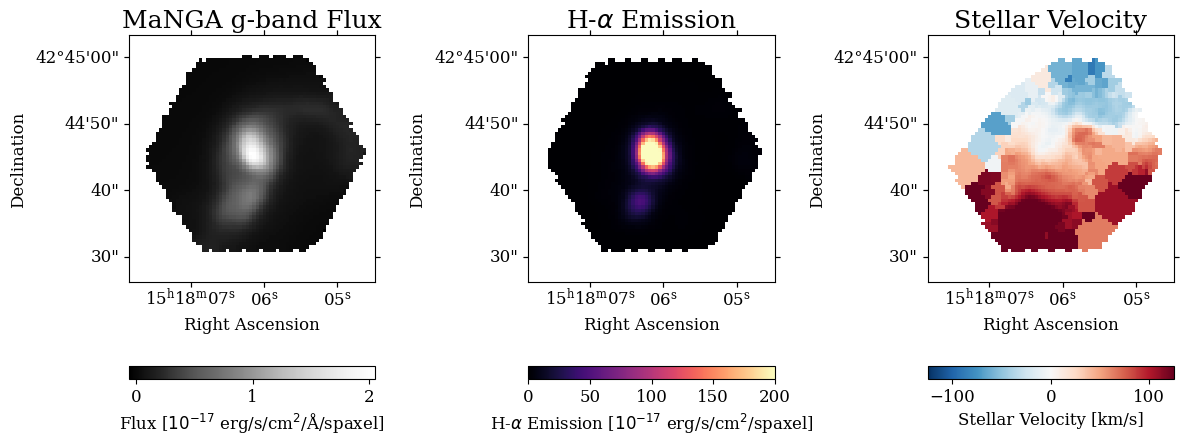

In [11]:
#=========================================
# Set up Plot
#=========================================
plt.figure(figsize=(12, 6))
# Grab the WCS information from the header
manga_wcs = WCS(manga_map['SPX_MFLUX'].header)
ax1 = plt.subplot(131, projection=manga_wcs)
ax2 = plt.subplot(132, projection=manga_wcs)
ax3 = plt.subplot(133, projection=manga_wcs)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')


#=========================================
# Subplot 1: MaNGA Flux Map
#=========================================
# The 'SPX_MFLUX' ext contains the g-band-weighted mean flux
manga_flux = manga_map['SPX_MFLUX'].data
manga_flux[manga_flux == 0] = np.nan # mask for quality data

# Plot image
im = ax1.imshow(manga_flux, cmap='Greys_r')
ax1.set_title('MaNGA g-band Flux')
plt.colorbar(im, label=r'Flux [$10^{-17}$ erg/s/cm$^{2}$/Å/spaxel]',
             orientation='horizontal')
             

#=========================================
# Subplot 2: MaNGA H-Alpha Emission Map
#=========================================

# Define the emission line indexes for this ext
emline = {}
for k, v in manga_map['EMLINE_GFLUX'].header.items():
    if k[0] == 'C':
        try:
            i = int(k[1:])-1
        except ValueError:
            continue
        emline[v] = i
        
# The 'EMLINE_GFLUX' ext contains the emission line measurements
h_alpha_flux = np.copy(manga_map['EMLINE_GFLUX'].data[emline['Ha-6564']])
h_alpha_flux[h_alpha_flux == 0] = np.nan # mask for quality data

# Plot image
im = ax2.imshow(h_alpha_flux, cmap='magma', vmin=0, vmax=200)
plt.colorbar(im, label=r'H-$\alpha$ Emission [$10^{-17}$ erg/s/cm$^{2}$/spaxel]',
             orientation='horizontal')

ax2.set_title(r'H-$\alpha$ Emission')

#=========================================
# Subplot 3: MaNGA Stellar Velocity Field
#=========================================
# The 'STELLAR_VEL' ext contains the stellar velocity measurements
qual_mask = manga_map['STELLAR_VEL'].header['QUALDATA'] # mask for quality data
velocity_map = np.ma.MaskedArray(manga_map['STELLAR_VEL'].data,
                                 mask=manga_map[qual_mask].data > 0)

# plot Image
im = ax3.imshow(velocity_map, interpolation='nearest', 
                vmin=-125, vmax=125, cmap='RdBu_r')

ax3.set_title(r'Stellar Velocity')
plt.colorbar(im, label=r'Stellar Velocity [km/s]',
             orientation='horizontal')

#plt.subplots_adjust(hspace=0)

plt.tight_layout()
plt.show()

***
<a id="HST"></a>
<a id="HST-query"></a>
# Searching for HST observations of this galaxy

## Coordinate search using astroquery.mast

Now let's search for HST obersvations of this same galaxy. Similar to before, we will be using `Observations.query_criteria()` to search the MAST archive, but this time, we will search for HST observations (`obs_collection='HST'`) near the coordinates of this MaNGA galaxy pair.

In [12]:
# Retrieve RA and DEC of MaNGA observations
ra = manga_obs_list['s_ra'][0]
dec = manga_obs_list['s_dec'][0]
# make a SkyCoord object from these coordinates
coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
print(coord)

# Search for HST observations based on coordinates
hst_obs = Observations.query_criteria(# Search by coordinates
                                      coordinates=coord, 
                                      # Search for HST observations
                                      obs_collection='HST',
                                      # Select only Science observations (not calibration files)
                                      intentType='science',
                                      # Select calibrated reduced observations
                                      provenance_name='CAL*') 

# Display Results
hst_obs

<SkyCoord (ICRS): (ra, dec) in deg
    (229.52558, 42.745842)>


intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str3,str6,str7,str3,str5,str8,str6,str72,str9,float64,float64,str5,str16,int64,float64,float64,float64,float64,float64,str92,float64,str5,str2,int64,str1018,str34,str35,str6,bool,float64,str8,str9,str9,float64
science,HST,CALWF3,WFC3/IR,HST,F160W,INFRARED,VV-705,GALAXY;INTERACTING GALAXY;MULTIPLE NUCLEI;ULTRALUMINOUS IR GAL;STARBURST,ia1e42010,229.52625,42.74361111111,image,"Surace, Jason A.",3,55191.08020185185,55191.14344517361,2395.398924,1393.8999999999999,1692.4,HST NICMOS Survey of the Nuclear Regions of Luminous Infrared Galaxies in the Local Universe,55556.22577551,11235,GO,--,POLYGON -130.45141896 42.72726823 -130.45139424562964 42.727623085811551 -130.45085739 42.72760092 -130.45083267175158 42.727955780706409 -130.45029576000002 42.72793361 -130.44791957 42.76202341 -130.44881279242628 42.762060290893743 -130.44877189 42.76264689 -130.50066389 42.76477749 -130.50068833934091 42.764422591918347 -130.50122566 42.76444453 -130.50125010335393 42.764089669031847 -130.5017873 42.7641116 -130.50413399 42.73002074 -130.50324120188574 42.729984288688932 -130.50328157 42.72939763 -130.45141896 42.72726823 -130.45141896 42.72726823,mast:HST/product/ia1e42010_drz.jpg,mast:HST/product/ia1e42010_drz.fits,PUBLIC,False,nan,24794549,673643046,673643046,0.0
science,HST,CALACS,ACS/WFC,HST,F814W,OPTICAL,VV705,GALAXY;INTERACTING GALAXY,j9cv55020,229.52625,42.74361111111,image,"Evans, Aaron S.",3,53688.73142982639,53688.74207797454,760.0,708.0,959.0,An ACS Survey of a Complete Sample of Luminous Infrared Galaxies in the Local Universe,54054.39680547,10592,GO,--,POLYGON -130.43207268999996 42.710149770000072 -130.43380304000004 42.738738559999888 -130.43390147880342 42.738740292976125 -130.43395158999988 42.739567809999961 -130.43429750999272 42.739573898841904 -130.43622134999993 42.766746739999988 -130.43631144527563 42.766749199904545 -130.43637000999993 42.767575989999933 -130.51272945999986 42.769635319999914 -130.51073934999991 42.742010469999961 -130.51064930025817 42.742008068768754 -130.51058976999991 42.741181329999925 -130.48078808475617 42.740382738212219 -130.51120778999976 42.740901790000045 -130.50944171000017 42.712314169999942 -130.50934332360208 42.712312501929482 -130.50929222999994 42.711485029999928 -130.43207268999996 42.710149770000072 -130.43207268999996 42.710149770000072,mast:HST/product/j9cv55020_drz.jpg,mast:HST/product/j9cv55020_drz.fits,PUBLIC,False,nan,24826350,679076123,679076123,0.0
science,HST,CALACS,ACS/WFC,HST,F435W,OPTICAL,VV705,GALAXY;INTERACTING GALAXY,j9cv55010,229.52625,42.74361111111,image,"Evans, Aaron S.",3,53688.666267974535,53688.685249456015,1320.0,370.0,479.99999999999994,An ACS Survey of a Complete Sample of Luminous Infrared Galaxies in the Local Universe,54054.37582171,10592,GO,--,POLYGON -130.43192424000009 42.709320519999878 -130.43365449999982 42.737909309999957 -130.4337529317022 42.737911043013639 -130.43380304000004 42.738738559999888 -130.43390147880342 42.738740292976125 -130.43395158999988 42.739567809999961 -130.4342075292484 42.739572315111893 -130.4360726999999 42.765917500000093 -130.43616278895598 42.765919959882218 -130.43622134999993 42.766746739999988 -130.43631144527563 42.766749199904545 -130.43637000999993 42.767575989999933 -130.51272945999986 42.769635319999914 -130.51073934999991 42.742010469999961 -130.51064930025817 42.742008068768754 -130.51058976999991 42.741181329999925 -130.51049972627087 42.741178928778268 -130.51047888276389 42.740889446885376 -130.51120778999976 42.740901790000045 -130.50944171000017 42.712314169999942 -130.50934332360208 42.712312501929482 -130.50929222999994 42.71148502999992

The table of results shown above tells us that there are three observations of this galaxy from HST, in three different filters: F160W, F435W, and F814W. Let's see what data products are available associated with these observations:

In [13]:
hst_products = Observations.get_product_list(hst_obs)

# Filter product list 
hst_products = Observations.filter_products(hst_products,
                                            # Select science files
                                            productType="SCIENCE",
                                            # Recommended Products
                                            productGroupDescription="Minimum Recommended Products", 
                                            # Select DRZ files - the calibrated combined images
                                            productSubGroupDescription='DRZ')
hst_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str3,str5,str35,str64,str1,str95,str9,str28,str11,str1,str7,str20,str5,str50,int64,str8,str6,int64,str9
24794549,HST,image,ia1e42010,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/ia1e42010_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALWF3,3.7.2 (Apr-15-2024),11235,ia1e42010_drz.fits,13587840,24794549,PUBLIC,3,F160W
24826349,HST,image,j9cv55010,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/j9cv55010_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALACS,DrizzlePac 3.9.0rc2,10592,j9cv55010_drz.fits,221261760,24826349,PUBLIC,3,F435W
24826350,HST,image,j9cv55020,DADS DRZ file - Calibrated combined image ACS/WFC3/WFPC2/STIS,D,mast:HST/product/j9cv55020_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,CALACS,DrizzlePac 3.9.0rc2,10592,j9cv55020_drz.fits,217800000,24826350,PUBLIC,3,F814W


With our products selected, we can proceed to download. We'll use `flat=True` to put them all into the same directory.

In [14]:
# Download products
Observations.download_products(hst_products, flat=True)

 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str20,str8,object,object
./ia1e42010_drz.fits,COMPLETE,None,None
./j9cv55010_drz.fits,COMPLETE,None,None
./j9cv55020_drz.fits,COMPLETE,None,None


<a id="HST-plot"></a>
## Plot the HST images

Let's plot the three HST images.

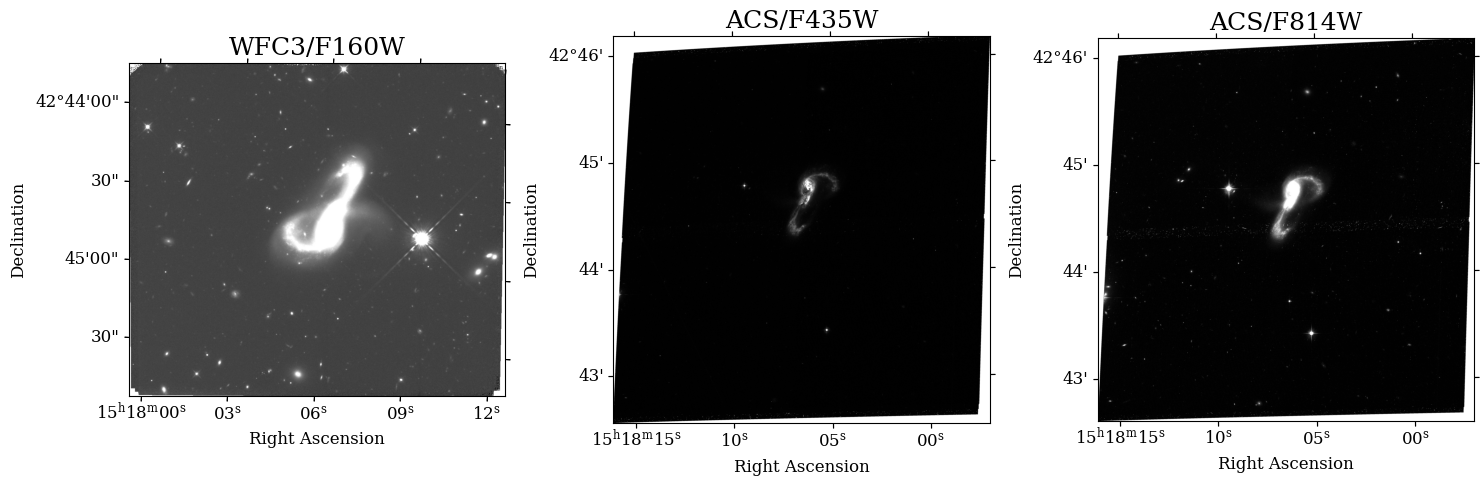

In [15]:
# Open files
f160w = fits.open('ia1e42010_drz.fits')
f435w = fits.open('j9cv55010_drz.fits')
f814w = fits.open('j9cv55020_drz.fits')


f160w_wcs = WCS(f160w[1].header)
f435w_wcs = WCS(f435w[1].header)
f814w_wcs = WCS(f814w[1].header)

#=========================================
# Set up Plot
#=========================================
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(131, projection=f160w_wcs)
ax2 = plt.subplot(132, projection=f435w_wcs)
ax3 = plt.subplot(133, projection=f814w_wcs)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')

#=========================================
# Subplot 1: F160W filter image
#=========================================
# Note - this image is upside-down compared to the other two
fits_file = f160w
ax1.imshow(fits_file[1].data, cmap='Greys_r', vmin=0, vmax=2.5, origin='lower')
ax1.set_title(f"{fits_file[0].header['INSTRUME']}/{fits_file[0].header['FILTER']}")

#=========================================
# Subplot 2: F435W filter image
#=========================================
fits_file = f435w
wcs = WCS(fits_file[1].header)
ax2.imshow(fits_file[1].data, cmap='Greys_r', vmin=0, vmax=0.5, origin='lower')
ax2.set_title(f"{fits_file[0].header['INSTRUME']}/{fits_file[0].header['FILTER2']}")

#=========================================
# Subplot 3: F814W filter image
#=========================================
fits_file = f814w
wcs = WCS(fits_file[1].header)
ax3.imshow(fits_file[1].data, cmap='Greys_r', vmin=0, vmax=0.5, origin='lower')
ax3.set_title(f"{fits_file[0].header['INSTRUME']}/{fits_file[0].header['FILTER2']}")

plt.tight_layout()
plt.show()

<a id="HST-colorize"></a>
## Colorizing HST images with astropy

We can combine all three HST images here and colorize them using the `make_lupton_rgb()` function from astropy. This function takes image data from three filter images, and combines them as an RGB image. In this example, we will order by wavelength and map the IR filter (F160W) to the red channel ('r'), the F814W filter to the green channel ('g'), and the F435W filter to the blue channel ('b').

Before we colorize the images, however, we need to reproject them onto the same coordinate system. We will resample the F160W and F814W images to the same projection as the F435W image, because the F435W image is the largest.


In [16]:
# Print image shapes:
print(f"F160W shape: {f160w[1].data.shape}")
print(f"F814W shape: {f814w[1].data.shape}")
print(f"F435W shape: {f435w[1].data.shape}")

# Reproject all three HST images into the same frame (using F435W image as base)
# This may take about a minute.
r, _ = reproject.reproject_interp(f160w[1], f435w[1].header)
g, _ = reproject.reproject_interp(f814w[1], f435w[1].header)
b, _ = reproject.reproject_interp(f435w[1], f435w[1].header)

# Colorize image using the three filters
hst_image = make_lupton_rgb(r*0.1, g, b*2.5, Q=4, stretch=0.75)

F160W shape: (996, 1124)
F814W shape: (4297, 4221)
F435W shape: (4358, 4228)


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/visualization/basic_rgb.py:153: RuntimeWarning: invalid value encountered in cast
  return image_rgb.astype(output_dtype)


Our reprojection and colorization is complete! Let's now plot the image.

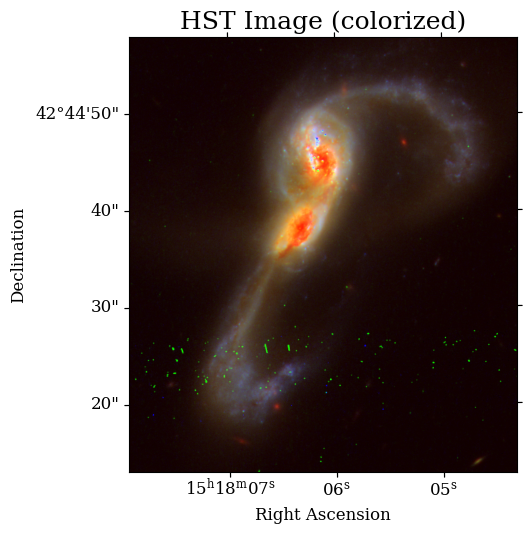

In [17]:
# Make plot
plt.figure(figsize=(5, 10))
ax = plt.subplot(projection=f435w_wcs)

# Plot image
ax.imshow(hst_image)

# Zoom in
ax.set_xlim(1800, 2600)
ax.set_ylim(2000, 2900)

# Label Plot
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title('HST Image (colorized)')
plt.show()

This image looks great! There are certainly a few places where bright spots in one image are affecting the final result; this can be seen as the green speckles across the lower third of the image.

***
<a id="HST-MaNGA"></a>
# Combining MaNGA and HST data

Now that we have downloaded both MaNGA and HST data, let's combine them into one plot to map some of properties of this merging pair of galaxies!

The key to combining the HST and MaNGA data is the [World Coordinate System (WCS)](https://astropy-astrofrog.readthedocs.io/en/latest/wcs/) transformations done by astropy. Using information from the file headers, `astropy.wcs()` will calculate the RA and DEC coordinates corresponding to each pixel in the image, allowing us to project both datasets on the same figure.

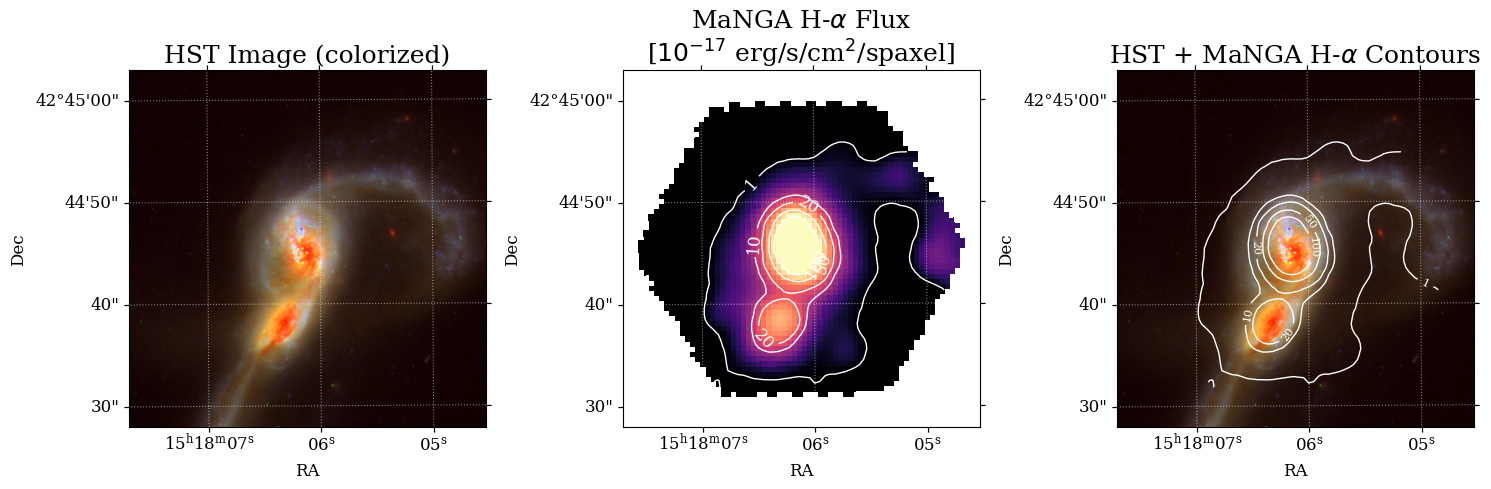

In [18]:
# Store WCS for easy coordinate transformations
hst_wcs = WCS(f435w[1].header)
manga_wcs = WCS(manga_map[3].header)

#=========================================
# Set up Plot
#=========================================
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(131, projection=hst_wcs)
ax2 = plt.subplot(132, projection=hst_wcs)
ax3 = plt.subplot(133, projection=hst_wcs)

for ax in [ax1, ax2, ax3]:
    # Zoom in
    ax.set_xlim(1850, 2550)
    ax.set_ylim(2300, 3000)
    # Label Axes
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    # Plot Grid
    ax.grid(color='white', ls='dotted', alpha=0.5)

    
#=========================================
# Subplot 1: HST Image
#=========================================
ax1.imshow(hst_image)
ax1.set_title('HST Image (colorized)')

#=========================================
# Subplot 2: MaNGA H-alpha Emission
#=========================================
ax2.set_title(r'MaNGA H-$\alpha$ Flux' + '\n' + r'[$10^{-17}$ erg/s/cm$^{2}$/spaxel]')

h_alpha_flux = np.copy(manga_map['EMLINE_GFLUX'].data[emline['Ha-6564']])
h_alpha_flux[h_alpha_flux == 0] = np.nan # mask for quality data


# Plot H-alpha flux
ax2.imshow(np.log10(h_alpha_flux),
           transform=ax2.get_transform(manga_wcs),
           cmap='magma', vmin=0, vmax=2)

# Plot MaNGA contours
contour_levels = [1, 10, 20, 50, 100]
contour_labels = [str(c) for c in contour_levels]
fmt = {}
for label_level, label_string in zip(contour_levels, contour_labels):
    fmt[label_level] = label_string

contours = ax2.contour(h_alpha_flux,
                       transform=ax2.get_transform(manga_wcs),
                       levels=contour_levels, colors='white')
ax2.clabel(contours, contours.levels, inline=True, fmt=fmt, fontsize=12)


#=========================================
# Subplot 3: HST + MaNGA
#=========================================
ax3.set_title(r'HST + MaNGA H-$\alpha$ Contours')

# Plot background HST image
ax3.imshow(hst_image)
    
# Plot MaNGA contours
contours = ax3.contour(h_alpha_flux,
                       transform=ax3.get_transform(manga_wcs),
                       levels=contour_levels, colors='white')
ax3.clabel(contours, contours.levels, inline=True, fmt=fmt, fontsize=8)


plt.tight_layout()
plt.show()

This plot encapsulates everything we have learned so far, showing the colorized HST image (left), the H-alpha flux from MaNGA (middle), and combining them both into a single image (right).


<a id="HST-MaNGA-Halpha"></a>
## Creating an H-alpha Emission Map

We can isolate the last panel and plot it by itself, too.

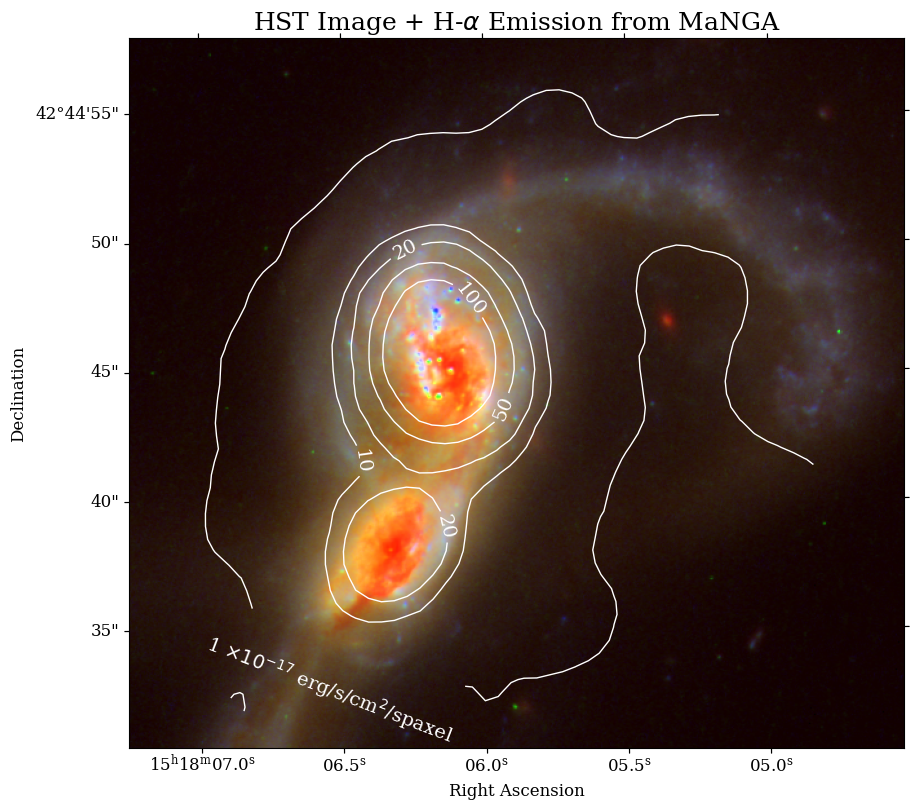

In [19]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=hst_wcs)
ax.set_xlim(1950, 2550)
ax.set_ylim(2350, 2900)
plt.xlabel(r'Right Ascension')
plt.ylabel(r'Declination')
plt.title(r'HST Image + H-$\alpha$ Emission from MaNGA')

# Plot the HST image
ax.imshow(hst_image)


# Plot MaNGA contours
contour_levels = [1, 10, 20, 50, 100]
contour_labels = [str(c) for c in contour_levels]
contour_labels[0] = r'1 $\times10^{-17}$ erg/s/cm$^{2}$/spaxel'
fmt = {}
for label_level, label_string in zip(contour_levels, contour_labels):
    fmt[label_level] = label_string

contours = ax.contour(h_alpha_flux,
                      transform=ax.get_transform(manga_wcs),
                      levels=contour_levels, colors='white')
ax.clabel(contours, contours.levels, inline=True, fmt=fmt, fontsize=14)

plt.savefig('manga_halpha_map.png')
plt.show()

In this figure, we can see that the H-alpha flux from MaNGA follows the spiral arms of the top galaxy, and the emission is strongest near the center of both galaxies.

<a id="HST-MaNGA-Velocity"></a>
## Plotting the stellar velocity field

Last but not least, let's do the same thing with the stellar velocity! The stellar velocity field from MaNGA will show which parts of the galaxies are redshifted (moving away from us, which we will plot in red), and which parts are blueshifted (moving toward us, which we will plot in blue).

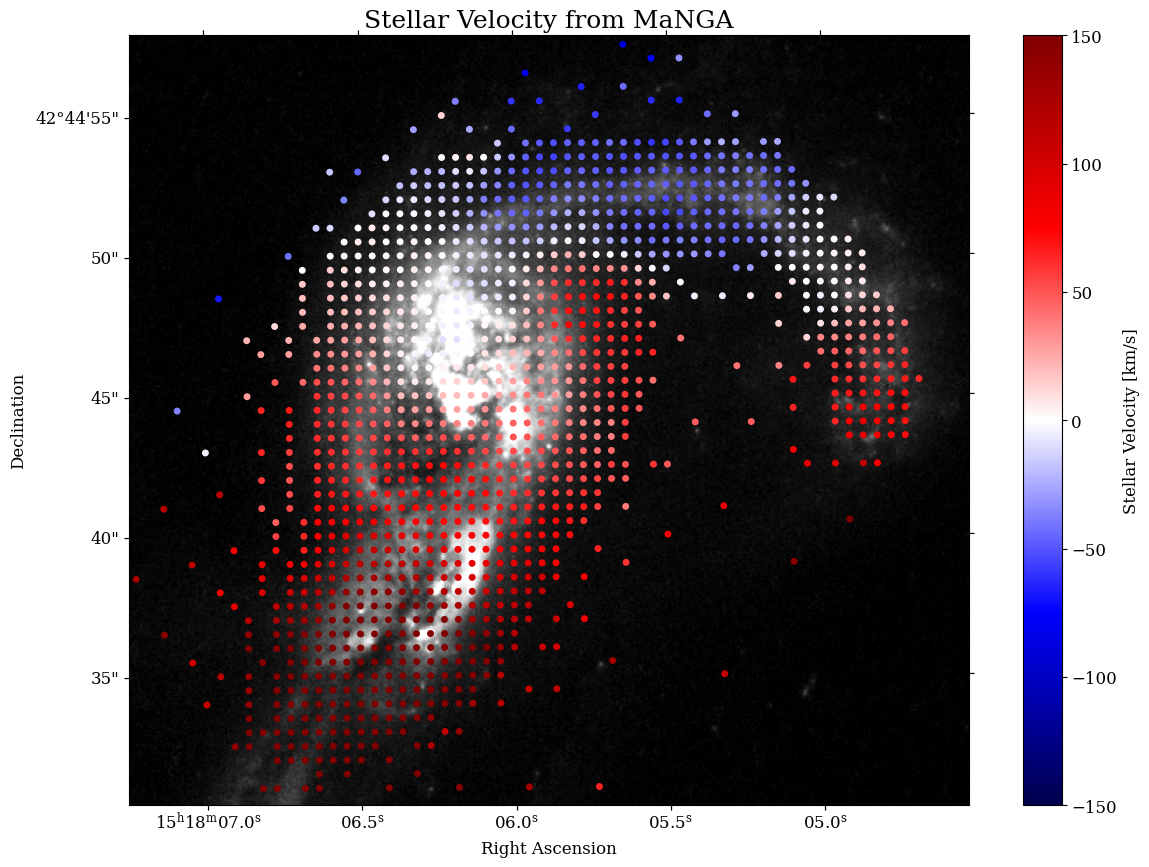

In [20]:
plt.figure(figsize=(14, 10))
ax = plt.subplot(projection=WCS(f435w[1].header))

ax.imshow(f435w[1].data, vmin=0, vmax=0.5, cmap='Greys_r',
          transform=ax.get_transform(WCS(f435w[1].header)))

ax.set_xlim(1950, 2550)
ax.set_ylim(2350, 2900)

bin_indx = manga_map['BINID'].data[1]
unique_bins, unique_indices = tuple(map(lambda x: x[1:],
                                        np.unique(bin_indx.ravel(), return_index=True)))

x_pix = np.array([x for y in range(74) for x in range(74)])[unique_indices]
y_pix = np.array([y for y in range(74) for x in range(74)])[unique_indices]
v_map = velocity_map.ravel()[unique_indices]

# Get the luminosity-weighted x and y coordinates of the unique bins
im = ax.scatter(x_pix, y_pix, c=v_map,
                marker='.', s=100, lw=0,
                vmin=-150, vmax=150, cmap='seismic', 
                transform=ax.get_transform(manga_wcs))

plt.colorbar(im, label='Stellar Velocity [km/s]')


plt.xlabel(r'Right Ascension')
plt.ylabel(r'Declination')
plt.title(r'Stellar Velocity from MaNGA')

plt.savefig('manga_velocity_map.png')
plt.show()

This plot shows that this galaxy pair is rotating vertically (from the perspective of this image). The arm in the upper galaxy is blueshifted, while most of the lower galaxy, and the end of the arm is redshifted.

***

Congratulations! You have reached the end of this tutorial notebook. You have learned how to access and download MaNGA data from MAST, and combine it with HST images to map different properties for this merging pair of galaxies.

<a id="Resources"></a>

## Additional Resources

Additional resources are linked below:

- [SDSS Legacy Archive at MAST](https://archive.stsci.edu/missions-and-data/sdss)
- [SDSS-IV MaNGA Survey](https://www.sdss4.org/surveys/manga/)
- [astroquery.mast User Manual](https://astroquery.readthedocs.io/en/latest/mast/mast.html)
- [MAST API](https://mast.stsci.edu/api/v0/index.html)


## Citations
<a id="Citations"></a>

If you use MaNGA data for published research, see the following links for information on which citations to include in your paper:

* [Citing SDSS](https://sdss.org/collaboration/citing-sdss/)
* [Citing MaNGA](https://www.sdss4.org/dr17/manga/manga-technical-papers/)
* [Citing MAST](https://archive.stsci.edu/publishing/mission-acknowledgements)
* [Citing astropy](https://www.astropy.org/acknowledging.html)


## About this Notebook

<a id="About"></a>

For questions or issues with this notebook, you can open a github issue or email archive@stsci.edu.

**Authors:** Julie Imig, Brian Cherinka <br>
**Keywords:** Tutorial, SDSS, MaNGA, HST, galaxies <br>
**First published:** October 2024 <br>
**Last updated:** October 2024 <br>

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/style-guides/master/guides/images/stsci-logo.png" alt="Space Telescope Logo" width="200px"/> 